# Pyaudio Microphone Streaming Examples
## WIP
The inital version of a simple notebook that uses pyaudio to get the microphone audio and feeds this audio then to Silero VAD.

In [1]:
import np
import os
import sys
import torch
torch.set_num_threads(1)
from pprint import pprint
import torchaudio
import librosa
import librosa.display
import matplotlib
import matplotlib.pylab as plt
from collections import deque
from pydub import AudioSegment
torchaudio.set_audio_backend("soundfile")

In [2]:
# Load them from the utils file
sys.path.append(os.path.abspath('utils_vad.py'))
from utils_vad import *

In [3]:
model, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=True)

Downloading: "https://github.com/snakers4/silero-vad/archive/master.zip" to /home/kaik/.cache/torch/hub/master.zip


In [4]:
def plotAudioFile(path):
    y, sr = librosa.load(path)
    plt.figure(figsize=(20, 6))
    librosa.display.waveplot(y, sr)

def int2float(sound):
    _sound = np.copy(sound)  # may be not necessary
    abs_max = np.abs(_sound).max()
    _sound = _sound.astype('float32')
    if abs_max > 0:
        _sound *= 1/abs_max
    _sound = _sound.squeeze()  # depends on the use case
    return _sound

In [5]:
import pyaudio
import io

FORMAT = pyaudio.paInt16
CHANNELS = 1
SAMPLE_RATE = 16000
CHUNK = int(SAMPLE_RATE / 10)

audio = pyaudio.PyAudio()

/home/kaik/Documents/Voicebridge/Repos/vad-comparison/env/lib/python3.8/site-packages/torch/nn/modules/module.py:889: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:639.)
  result = self.forward(*input, **kwargs)


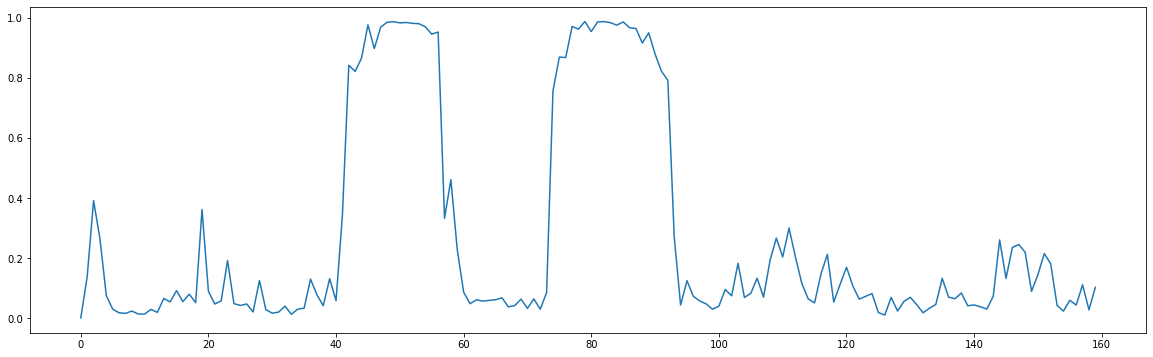

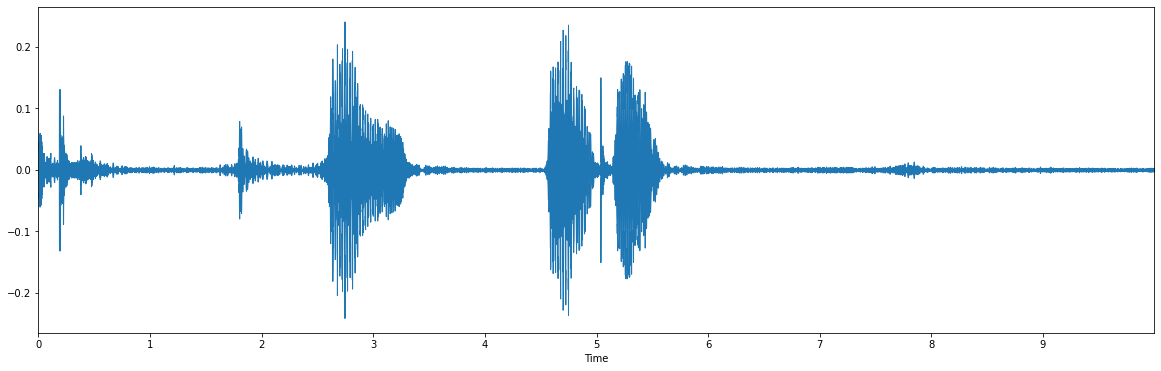

In [7]:
streaming_iterator = VADiteratorAdaptive()
stream = audio.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=SAMPLE_RATE,
                    input=True,
                    frames_per_buffer=CHUNK)
data = []
voiced_confidences = []

for i in range(0, 20):
    frame_duration_ms = 250
    audio_chunk = stream.read(int(SAMPLE_RATE * frame_duration_ms / 1000.0))
    
    data.append(audio_chunk)
    
    audio_int16 = np.frombuffer(audio_chunk, np.int16);

    audio_float32 = int2float(audio_int16)
    batch = streaming_iterator.prepare_batch(torch.from_numpy(audio_float32))
    
    # get the confidences and add them to the list to plot them later
    vad_outs = validate(model, batch)
    for item in vad_outs[:,1]:
        voiced_confidences.append(item)

# Please note the different x axes scales of the plots
# plot the confidences for the speech
plt.figure(figsize=(20,6))
plt.plot(voiced_confidences)

# plot the waveplot of the recorded audio
data = b''.join(data)
mocked_file = io.BytesIO(data)
audio_segment = AudioSegment.from_raw(file=mocked_file, channels=1, frame_rate=8000, sample_width=2)
audio_segment.export("test.wav", format="wav")
plotAudioFile("test.wav")